# Tomographic Reconstruction (synthetic data)

Here, we calculate reconstructed images from a ray-traced image (synthetic data) with the L-curve
criterion, and evaluate the tomography result with true solution (phantom).


In [1]:
from pathlib import Path
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.lib.format import open_memmap
from numpy.typing import NDArray
from raysect.optical import Point3D, Spectrum, Vector3D, World

from cherab.phix.inversion import Lcurve
from cherab.phix.plasma import import_plasma
from cherab.phix.tools import profile_1D_to_2D, profile_2D_to_1D
from cherab.phix.tools.raytransfer import import_phix_rtc
from cherab.phix.tools.visualize import show_phix_profiles

plt.rcParams["figure.dpi"] = 150

# Path diffinition
POWER_DATA = Path().cwd().parent / "data" / "synthetic_data" / "2020_07_25_01_51_55" / "Power.npy"
SVD_DIR = (
    Path().cwd().parent.parent.parent / "output" / "RTM" / "2022_12_13_00_49_29" / "w_laplacian"
)

# Create scene objects
world = World()
plasma, eq = import_plasma(world)
rtc = import_phix_rtc(world, equilibrium=eq)

loading plasma (data from: phix10)...


## Construct the $\text{H}_\alpha$ emissivity 2D profile

To compare the reconstructed emissivity to true one, we calculate true emissivity
from PHiX plasma object.


In [2]:
models = [i for i in plasma.models]
pprint(models)

[<PlasmaModel - Bremsstrahlung>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(3, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(4, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(5, 2)>,
 <ExcitationLine: element=hydrogen, charge=0, transition=(6, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(3, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(4, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(5, 2)>,
 <RecombinationLine: element=hydrogen, charge=0, transition=(6, 2)>]


In [3]:
# set constants
nr = rtc.material.grid_shape[0]
nz = rtc.material.grid_shape[2]
rmin = rtc.material.rmin
zmin = rtc.transform[2, 3]
rmax = rmin + rtc.material.dr * nr
zmax = zmin + rtc.material.dz * nz

xrange = np.linspace(rmin, rmax, nr)
yrange = np.linspace(zmin, zmax, nz)

Halpha = (655.6, 656.8)
Halpha_model = [models[1], models[5]]
emissivity = np.zeros((nr, nz))
spectrum_bins = 50

# sample emissivity
for i, x in enumerate(xrange):
    for j, y in enumerate(yrange):
        for model in Halpha_model:
            emissivity[i, j] += (
                model.emission(
                    Point3D(x, 0.0, y),
                    Vector3D(0, 1, 0),
                    Spectrum(Halpha[0], Halpha[1], spectrum_bins),
                ).total()
                * 4.0
                * np.pi
            )  # [W/m^3/str] -> [W/m^3]

Show the $\text{H}_\alpha$ emissivity profile


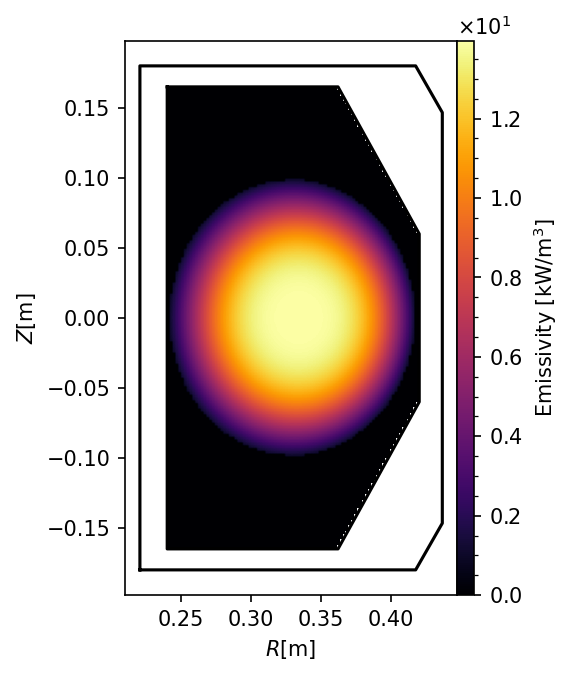

In [4]:
fig, ax = show_phix_profiles(emissivity * 1e-3, rtc=rtc, clabel="Emissivity [kW/m$^3$]")

Convert 2D array to 1D array corresponding to the ray-transfer object size.


In [5]:
emissivity_1d = profile_2D_to_1D(emissivity, rtc=rtc)

## Load synthetic power data

Load the ray-traced camera image to use it as tomography data


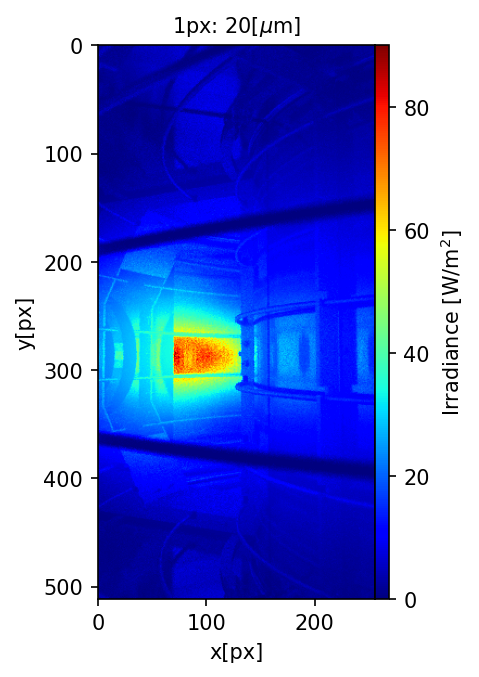

In [6]:
# load image
data = np.load(POWER_DATA)

# show
fig = plt.figure()
grids = ImageGrid(fig, 111, nrows_ncols=(1, 1), cbar_mode="single", cbar_pad=0.0)
mappable = grids[0].imshow(data.T / (20e-6) ** 2, cmap="jet")
cbar = plt.colorbar(mappable, cax=grids.cbar_axes[0])
cbar.set_label("Irradiance [W/m$^2$]")
grids[0].set_xlabel("x[px]")
grids[0].set_ylabel("y[px]")
grids[0].set_title("1px: 20[$\\mu$m]", size=10);

## Tomographic Reconstruction with L-curve criterion


Load SVD components using `numpy.memmap` array.


In [7]:
s = open_memmap(SVD_DIR / "s.npy")
u = open_memmap(SVD_DIR / "u.npy")
basis = open_memmap(SVD_DIR / "L_inv_V.npy")

Instantiate `Lcurve` class


In [8]:
lcurve = Lcurve(s, u, basis, data=data.ravel())

Solve the tomographic reconstruction using the L-curve criterion


In [9]:
bounds = (-23, -17)
sol, status = lcurve.solve(bounds=bounds, disp=False)
pprint(status)

{'fun': -3.049906249376925,
 'lowest_optimization_result': {'fun': -3.049906249376925,
                                'hess_inv': <1x1 LbfgsInvHessProduct with dtype=float64>,
                                'jac': array([1.77635669e-06]),
                                'message': 'CONVERGENCE: '
                                           'NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
                                'nfev': 26,
                                'nit': 6,
                                'njev': 13,
                                'status': 0,
                                'success': True,
                                'x': array([-18.46593465])},
 'message': ['requested number of basinhopping iterations completed '
             'successfully'],
 'minimization_failures': 0,
 'nfev': 2216,
 'nit': 100,
 'njev': 1108,
 'success': True,
 'x': array([-18.46593465])}


Plot L-curve and its curvature. The red cross point corresponds to the optimal regularization parameter.


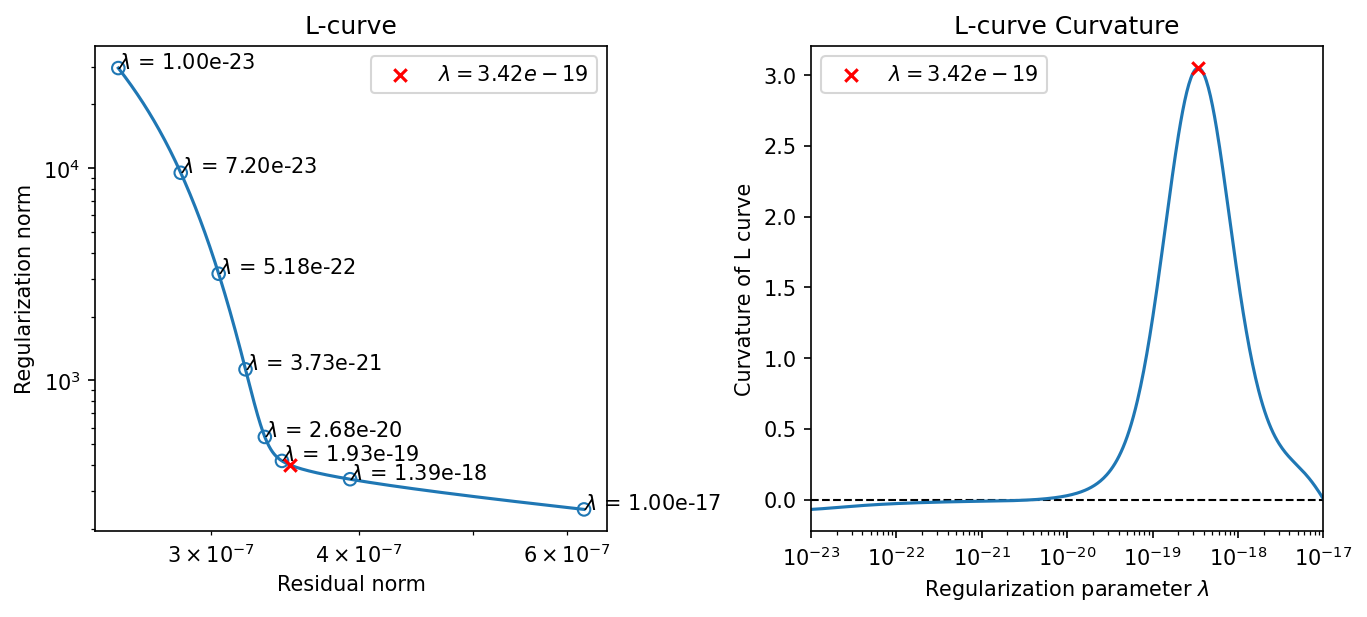

In [10]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(9, 4))

# L-curve plot
lcurve.plot_L_curve(fig=fig, axes=axes[0], scatter_plot=8, bounds=bounds, n_beta=500)
axes[0].set_title("L-curve")
axes[0].legend()

# curvature plot
lcurve.plot_curvature(fig=fig, axes=axes[1], bounds=bounds, n_beta=500)
axes[1].set_title("L-curve Curvature")
axes[1].legend()

Compare the reconstructed emissivity and true (original) one.


Text(0.5, 1.0, 'Reconstructed solution $x_\\lambda$')

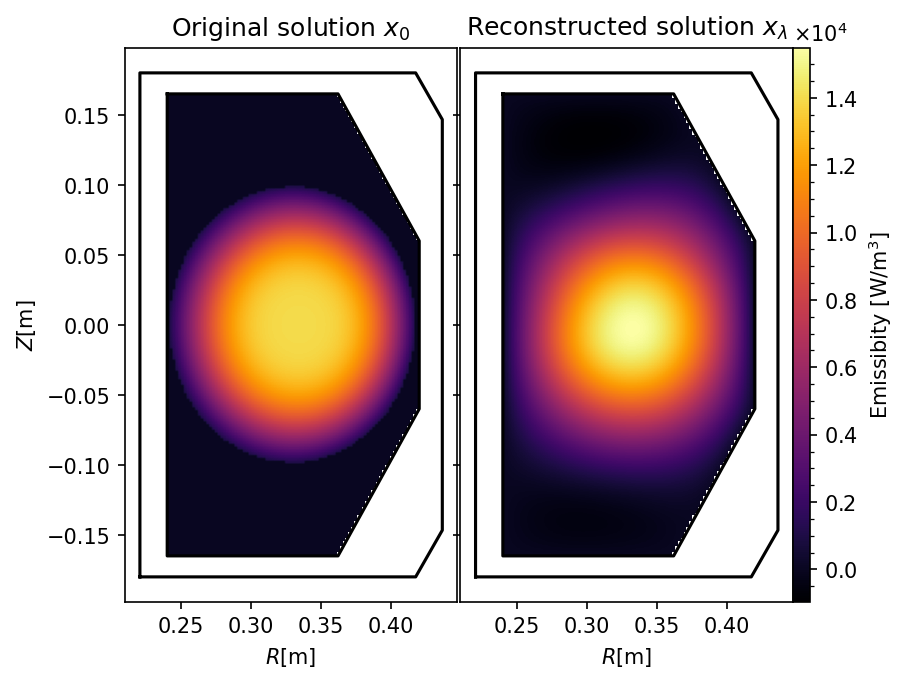

In [11]:
fig, axes = show_phix_profiles(
    [emissivity, profile_1D_to_2D(sol * 4.0 * np.pi, rtc=rtc)],
    clabel="Emissibity [W/m$^3$]",
)
axes[0].set_title("Original solution $x_0$")
axes[1].set_title("Reconstructed solution $x_\\lambda$")

Show only the reconstructed image with negative values at the optimal regularization parameter.


Text(0.5, 1.0, 'Reconstructed profile')

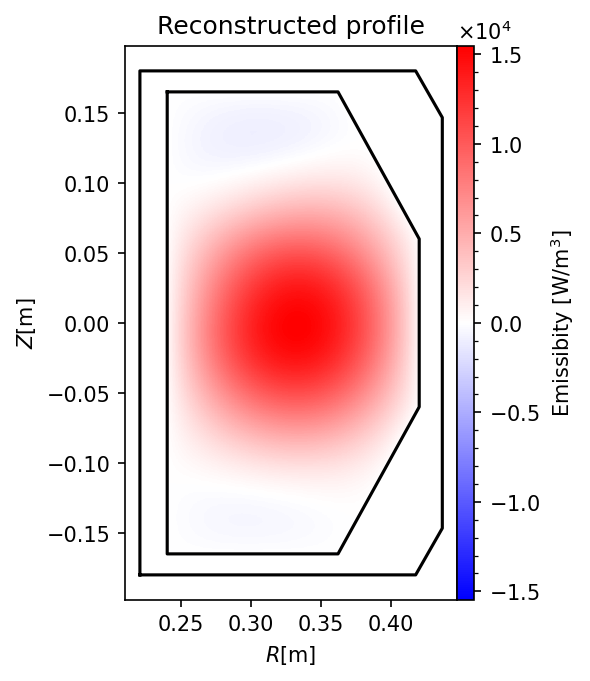

In [12]:
fig, axes = show_phix_profiles(
    [profile_1D_to_2D(sol * 4.0 * np.pi, rtc=rtc)],
    clabel="Emissibity [W/m$^3$]",
    cmap="bwr",
    plot_mode="centered",
)
axes[0].set_title("Reconstructed profile")

## Deffinition of the relative error function

To evaluate the optimal inversion solution, let us define the following error function:

$$
e(\lambda) \equiv \frac{||x_0 - x_\lambda||}{||x_0||} \times 100 \ [\%].
$$


In [13]:
def error(x_0: NDArray, lcurve: Lcurve, beta: float) -> np.floating:
    """Compute Relative error value

    Parameters
    ----------
    x_0 : NDArray 1D
        True solution vector [W/m^3]
    lcurve : Lcurve
        Lcurve class instance
    beta : float
        regularization parameter

    Return
    ------
    float
        relative error percentage
    """
    return (
        100.0
        * np.linalg.norm(x_0 - lcurve.inverted_solution(beta) * 4.0 * np.pi)
        / np.linalg.norm(x_0)
    )

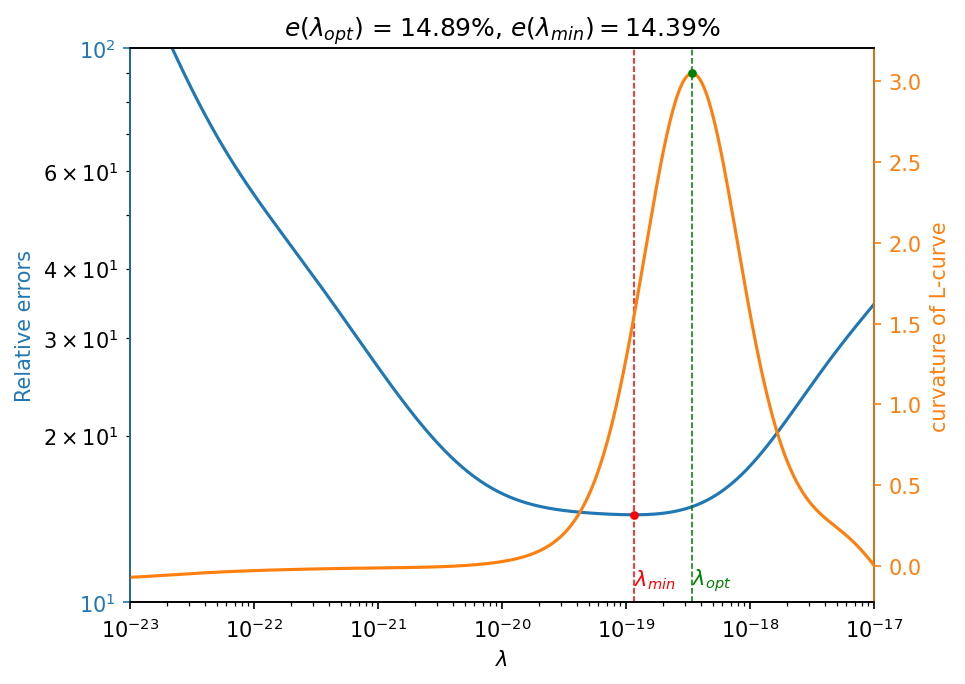

In [14]:
# set regularization parameters
lambdas = np.logspace(*bounds, 500)

# calculate errors
errors = np.asarray([error(emissivity_1d, lcurve, beta) for beta in lambdas])
lambda_min = lambdas[errors.argmin()]
error_min = errors.min()
error_opt = error(emissivity_1d, lcurve, lcurve.lambda_opt)

# calculate curvatures
kappa = np.asarray([lcurve.curvature(beta) for beta in lambdas])

# create figure
fig, ax1 = plt.subplots(dpi=150)
ax2 = ax1.twinx()

# plot errors and curvatures
(p1,) = ax1.loglog(lambdas, errors, color="C0")
(p2,) = ax2.semilogx(lambdas, kappa, color="C1")

# ylim
ylim = (10, 100)

# plot minimum error vertical line and point
ax1.vlines(lambda_min, *ylim, color="r", linestyle="--", linewidth=0.75)
ax1.scatter(lambda_min, error_min, color="r", marker="o", s=10, zorder=2)
ax1.text(
    lambda_min,
    ylim[0] * 1.1,
    "$\\lambda_{min}$",
    color="r",
    horizontalalignment="left",
    verticalalignment="center",
)

# plot maximum curvature vertical line and point
ax1.vlines(lcurve.lambda_opt, *ylim, color="g", linestyle="--", linewidth=0.75)
ax2.scatter(lcurve.lambda_opt, lcurve.curvature(lcurve.lambda_opt), color="g", marker="o", s=10, zorder=2)
ax1.text(
    lcurve.lambda_opt,
    ylim[0] * 1.1,
    "$\\lambda_{opt}$",
    color="g",
    horizontalalignment="left",
    verticalalignment="center",
)

# set axes
ax1.set(
    xlim=(lambdas[0], lambdas[-1]), ylim=ylim, xlabel=r"$\lambda$", ylabel="Relative errors"
)
ax2.set(ylabel="curvature of L-curve")

ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

ax1.tick_params(axis="y", colors=p1.get_color())
ax2.tick_params(axis="y", colors=p2.get_color())

ax2.spines["left"].set_color(p1.get_color())
ax2.spines["right"].set_color(p2.get_color())

ax1.set_title(
    "$e(\\lambda_{})$ = {:.2%}, $e(\\lambda_{}) = ${:.2%}".format(
        "{opt}", error_opt * 1e-2, "{min}", error_min * 1e-2
    )
);

Compare inverted solution with original and minimam error solutions.
To evaluate positive and negative anomalies around a center 0, we take the centered colormap to show
the profiles.


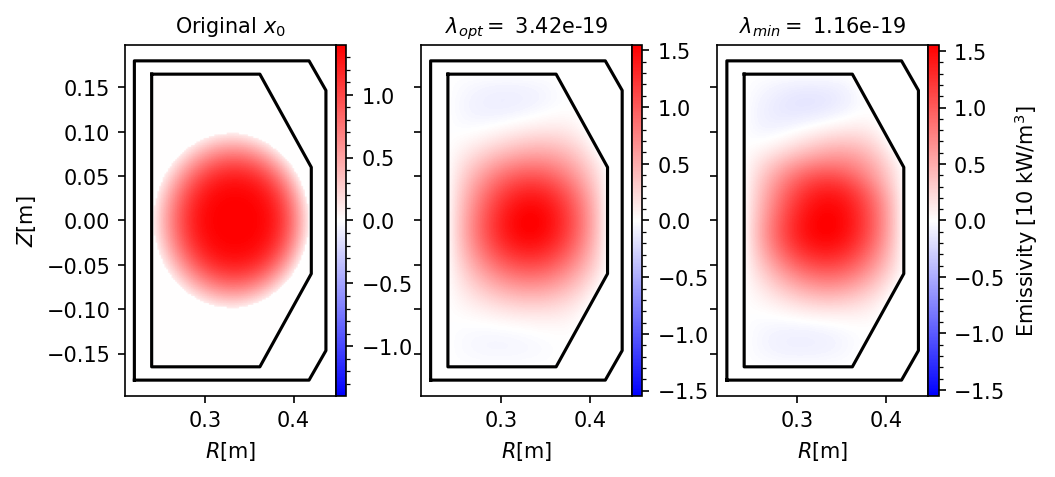

In [15]:
fig, grids = show_phix_profiles(
    [
        emissivity * 1e-4,
        profile_1D_to_2D(sol * 4.0 * np.pi, rtc=rtc) * 1e-4,
        profile_1D_to_2D(lcurve.inverted_solution(lambda_min) * 4.0 * np.pi, rtc) * 1e-4,
    ],
    axes_pad=0.5,
    cbar_mode="each",
    cmap="bwr",
    plot_mode="centered",
)

grids.cbar_axes[2].set_ylabel("Emissivity [10 kW/m$^3$]")

grids[0].set_title("Original $x_0$", size=10)
grids[1].set_title(f"$\\lambda_{{opt}} =$ {lcurve.lambda_opt:.2e}", size=10)
grids[2].set_title(f"$\\lambda_{{min}} =$ {lambda_min:.2e}", size=10)
fig.set_size_inches(7, 7)

## Vertical cross-section of solutions


Text(0, 0.5, 'Radiance per meter [W/m$^3$]')

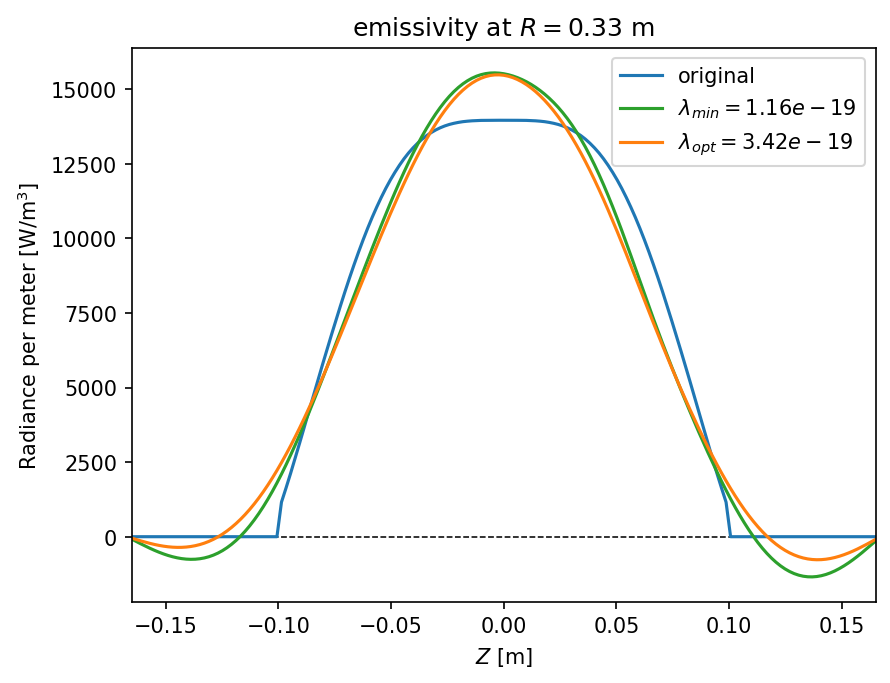

In [16]:
z = (
    np.linspace(
        -165 + rtc.material.dz * 0.5, 165 - rtc.material.dz * 0.5, rtc.material.grid_shape[2]
    )
    * 1e-3
)
r = np.linspace(
    rtc.material.rmin + rtc.material.dr * 0.5,
    rtc.material.rmin + rtc.material.dr * rtc.material.grid_shape[0] - rtc.material.dr * 0.5,
    rtc.material.grid_shape[0],
)
minimum_solution = profile_1D_to_2D(lcurve.inverted_solution(lambda_min), rtc) * 4.0 * np.pi
optimized_solution = profile_1D_to_2D(sol, rtc) * 4.0 * np.pi
plt.plot(z, emissivity[45, :], c="C0", label="original")
plt.plot(z, minimum_solution[45, :], c="C2", label=f"$\\lambda_{{min}} = {lambda_min:.2e}$")
plt.plot(
    z, optimized_solution[45, :], c="C1", label=f"$\\lambda_{{opt}} = {lcurve.lambda_opt:.2e}$"
)
plt.plot([z.min(), z.max()], [0, 0], "--", color="k", zorder=-1, linewidth=0.75)
plt.legend()
plt.xlim(z.min(), z.max())
plt.title(f"emissivity at $R = {r[45]:.2f}$ m")
plt.xlabel("$Z$ [m]")
plt.ylabel("Radiance per meter [W/m$^3$]")